# 飞桨常规赛：PALM病理性近视预测  5月第7名方案

```
为了进行交叉验证及模型集成，我把数据集按照4:1划分了5次，得到train_0.txt~train_4.txt及val_0.txt~val_4.txt。
这个最好的结果是在train_1.txt上训练带有预训练的mobilenet_v1，用最好的模型预测得到的。
后来还做了半监督学习、模型结果求均值等都没得到更好的结果。
还有评价指标我只用了ACC没有用AUC。
```

In [2]:
#解压数据集至data目录
!unzip -oq /home/aistudio/data/data93479/常规赛：PALM病理性近视预测.zip -d data/

In [4]:
#导包
import paddle
import numpy as np
from paddle.vision import transforms
from paddle import optimizer as optim
from paddle.io import Dataset
import matplotlib.pylab as plt
import os
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
print("paddle's version:", paddle.__version__)

paddle's version: 2.0.2


# 准备数据

In [5]:
def create_txt(data_root, train_dir=None, test_dir=None, val_pro=0.2, is_cross_val=False, k=None):#当is_cross_val=True时，k必须有正整值
    if train_dir is not None:
        if os.path.exists("train.txt"):
            os.remove("train.txt")
        if os.path.exists("val.txt"):
            os.remove("val.txt")
        train_path = os.path.join(data_root, train_dir)
        dir_list = sorted(os.listdir(train_path))#['.DS_Store', 'Classification.xlsx', 'fundus_image']
        label_path = os.path.join(train_path, dir_list[1])
        all_train_data = pd.read_excel(label_path)
        #打乱数据
        all_train_data = all_train_data.sample(frac=1.0, random_state=2021).reset_index(drop=True)
        if is_cross_val is False:
            val_len = int(len(all_train_data)*val_pro)
            val_data = all_train_data.iloc[:val_len]
            train_data = all_train_data.iloc[val_len:]
            with open("train.txt", 'w') as f:
                for i in range(len(train_data)):
                    img_path = os.path.join(train_path, dir_list[2], train_data.iloc[i, 0])
                    label = train_data.iloc[i, 1]
                    f.write(img_path+","+str(label)+"\n")
            with open("val.txt", 'w') as f:
                for i in range(len(val_data)):
                    img_path = os.path.join(train_path, dir_list[2], val_data.iloc[i, 0])
                    label = val_data.iloc[i, 1]
                    f.write(img_path+","+str(label)+"\n")
        else:
            val_len = len(all_train_data)//k
            for m in range(k):
                val_data = all_train_data.iloc[val_len*m:val_len*(m+1)]
                train_data = pd.concat([all_train_data.iloc[:val_len*m], all_train_data.iloc[val_len*(m+1):]], axis=0)
                train_txt = "train_"+str(m)+".txt"
                val_txt = "val_"+str(m)+".txt"
                with open(train_txt, 'w') as f:
                    for i in range(len(train_data)):
                        img_path = os.path.join(train_path, dir_list[2], train_data.iloc[i, 0])
                        label = train_data.iloc[i, 1]
                        f.write(img_path+","+str(label)+"\n")
                with open(val_txt, 'w') as f:
                    for i in range(len(val_data)):
                        img_path = os.path.join(train_path, dir_list[2], val_data.iloc[i, 0])
                        label = val_data.iloc[i, 1]
                        f.write(img_path+","+str(label)+"\n")
    print("训练数据整理完毕！训练集长度：{}，验证集长度：{}".format(len(train_data), val_len))

    if test_dir is not None:
        if os.path.exists("test.txt"):
            os.remove("test.txt")
        test_path = os.path.join(data_root, test_dir)
        test_imgs_path_list = sorted(os.listdir(test_path))
        with open("test.txt", 'w') as f:
            for path in test_imgs_path_list:
                img_path = os.path.join(test_path, path)
                f.write(img_path+"\n")
    print("测试数据整理完毕！测试集长度：{}".format(len(test_imgs_path_list)))

In [7]:
data_root = "data/常规赛：PALM病理性近视预测"
train_dir = "Train"
test_dir = "PALM-Testing400-Images"
create_txt(data_root=data_root, train_dir=train_dir, test_dir=test_dir)#, is_cross_val=True, k=5)

训练数据整理完毕！训练集长度：640，验证集长度：160
测试数据整理完毕！测试集长度：400


In [ ]:
#验证一下是否写入正确，可以直接点开文件查看
#也可以读取文件内容查看
#以train.txt为例，只看前5行验证
count = 5
with open('train.txt', 'r')  as f:
    for line in f.readlines():
        print(line)
        count -= 1
        if count==0:
            break

data/常规赛：PALM病理性近视预测/Train/fundus_image/V0174.jpg,0

data/常规赛：PALM病理性近视预测/Train/fundus_image/V0316.jpg,1

data/常规赛：PALM病理性近视预测/Train/fundus_image/V0061.jpg,0

data/常规赛：PALM病理性近视预测/Train/fundus_image/P0011.jpg,1

data/常规赛：PALM病理性近视预测/Train/fundus_image/V0085.jpg,1



label: 1

image shape: (2056, 2124, 3)


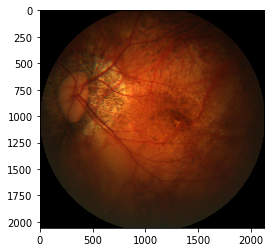

In [ ]:
#打开一张图片观察一下
img_path, label = line.split(',')[0], line.split(',')[1]
img = Image.open(img_path)
print('label:', label)
print('image shape:', np.array(img).shape)
plt.imshow(img)
plt.show()
#属于病理性近视

In [ ]:
#构建Dataset
class MyDataset(Dataset):
    def __init__(self, file_name, mode, transform=None):
        assert mode=="train" or mode=="val" or mode=="test", "ERROR:mode must be train, val or test."
        self.img_path_list = []
        self.label_list = []
        #打开存放图片路径的.txt文件，得到图片路径列表和对应标签列表
        with open(file_name, 'r') as f:
            for line in f.readlines():
                line = line.strip().split(',')
                self.img_path_list.append(line[0])
                if mode!='test':#测试集没有标签
                    self.label_list.append(int(line[1]))        
        
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        #读取图片，（H,W,C）
        img = Image.open(self.img_path_list[idx])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        #应用数据增强
        if self.transform is not None:
            img = self.transform(img).astype('float32')
        
        if self.mode!='test':
            label = np.array(self.label_list[idx])
            return img, label
        else:
            return [img]

    def __len__(self):
        return len(self.img_path_list)

In [ ]:
#数据增强
image_size = 224
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),#改变大小
    transforms.RandomHorizontalFlip(),#水平翻转
    transforms.RandomVerticalFlip(),#垂直翻转
    transforms.RandomRotation(90),#随机旋转
    transforms.Transpose(),
    transforms.Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5])#归一化
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),#改变大小
    transforms.Transpose(),
    transforms.Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5])#归一化
])

#顺序得到train_data, val_data, test_data
train_data = MyDataset(file_name='train.txt', mode='train', transform=train_transform)
val_data = MyDataset(file_name='val.txt', mode='val', transform=test_transform)
test_data = MyDataset(file_name='test.txt', mode='test', transform=test_transform)
print("train data length:", len(train_data))
print("val data length:", len(val_data))
print("test data length:", len(test_data))

train data length: 640
val data length: 160
test data length: 400


In [ ]:
# 查看数据大小和标签
for img, label in train_data:
    print("img shape:", img.shape)
    print("label:", label)
    print(img)
    break

img shape: (3, 224, 224)
label: 0.0
[[[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]]


# 搭建模型

In [83]:
#使用paddle自己的预训练模型
net = paddle.vision.models.mobilenet_v1(num_classes=2, pretrained=True)
model = paddle.Model(net)
model.summary((-1, 3, 224, 224)) 

2021-05-09 00:06:29,726 - INFO - unique_endpoints {''}
[INFO 2021-05-09 00:06:29,726 download.py:154] unique_endpoints {''}
2021-05-09 00:06:29,727 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/mobilenet_v1_x1.0.pdparams md5 checking...
[INFO 2021-05-09 00:06:29,727 download.py:251] File /home/aistudio/.cache/paddle/hapi/weights/mobilenet_v1_x1.0.pdparams md5 checking...
2021-05-09 00:06:29,835 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/mobilenet_v1_x1.0.pdparams
[INFO 2021-05-09 00:06:29,835 download.py:184] Found /home/aistudio/.cache/paddle/hapi/weights/mobilenet_v1_x1.0.pdparams


----------------------------------------------------------------------------------
     Layer (type)          Input Shape          Output Shape         Param #    
      Conv2D-190        [[1, 3, 224, 224]]   [1, 32, 112, 112]         864      
   BatchNorm2D-190     [[1, 32, 112, 112]]   [1, 32, 112, 112]         128      
       ReLU-190        [[1, 32, 112, 112]]   [1, 32, 112, 112]          0       
   ConvBNLayer-190      [[1, 3, 224, 224]]   [1, 32, 112, 112]          0       
      Conv2D-191       [[1, 32, 112, 112]]   [1, 32, 112, 112]         288      
   BatchNorm2D-191     [[1, 32, 112, 112]]   [1, 32, 112, 112]         128      
       ReLU-191        [[1, 32, 112, 112]]   [1, 32, 112, 112]          0       
   ConvBNLayer-191     [[1, 32, 112, 112]]   [1, 32, 112, 112]          0       
      Conv2D-192       [[1, 32, 112, 112]]   [1, 64, 112, 112]        2,048     
   BatchNorm2D-192     [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
       ReLU-192        [[1

{'total_params': 3230914, 'trainable_params': 3187138}

In [86]:
#配置训练配置
epochs = 100
batch_size = 64
lr = 3e-4
weight_decay = 5e-4
save_dir = "mobilenet_v1_2"
#lr = optim.lr.CosineAnnealingDecay(learning_rate=lr, T_max=200, eta_min=3e-6, last_epoch=-1, verbose=False)
optimizer = optim.AdamW(learning_rate=lr, parameters=model.parameters())

model.prepare(optimizer=optimizer, #指定优化器
                loss=paddle.nn.CrossEntropyLoss(), #指定损失函数
                metrics=paddle.metric.Accuracy()) #指定评估方法

#用于visualdl可视化
visualdl = paddle.callbacks.VisualDL(log_dir=save_dir)
#早停机制，在eval_acc不增大10个epoch时停止训练并保存最佳模型
early_stop = paddle.callbacks.EarlyStopping(
                                            'loss',
                                            mode='auto',
                                            patience=10,
                                            verbose=1,
                                            min_delta=0,
                                            baseline=None,
                                            save_best_model=True)

In [ ]:
#########训练
model.fit(train_data=train_data,     #训练数据集
            eval_data=val_data,       #测试数据集
            batch_size=batch_size,         #一个批次的样本数量
            epochs=epochs,                  #迭代轮次
            save_dir=save_dir, #把模型参数、优化器参数保存至自定义的文件夹
            save_freq=5,                    #设定每隔多少个epoch保存模型参数及优化器参数
            shuffle=True,
            verbose=1,
            callbacks=[visualdl, early_stop]
)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/100
step 10/10 [==============================] - loss: 0.1279 - acc: 0.9078 - 5s/step
save checkpoint at /home/aistudio/mobilenet_v1_6/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 3/3 [==============================] - loss: 0.0686 - acc: 0.9625 - 4s/step
Eval samples: 160
Epoch 2/100
step 10/10 [==============================] - loss: 0.0684 - acc: 0.9734 - 5s/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 3/3 [==============================] - loss: 0.0472 - acc: 0.9625 - 4s/step
Eval samples: 160
Epoch 3/100
step 10/10 [==============================] - loss: 0.0261 - acc: 0.9812 - 5s/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of 

# 用最好的模型预测

In [87]:
model_path = "mobilenet_v1_2/best_model.pdparams"
model.load(model_path)

In [79]:
results = model.predict(test_data)

Predict begin...
step 149/149 [==============================] - 88ms/step        
Predict samples: 149


In [ ]:
new_results = paddle.nn.functional.softmax(paddle.to_tensor(np.array(results).squeeze(0).squeeze(1)), axis=-1).numpy()[:, 1]
print(new_results.shape)
file_name = sorted(os.listdir("data/常规赛：PALM病理性近视预测/PALM-Testing400-Images"))
print(file_name[:5])

(400,)
['T0001.jpg', 'T0002.jpg', 'T0003.jpg', 'T0004.jpg', 'T0005.jpg']


In [ ]:
#生成csv文件
df = pd.DataFrame({'FileName': file_name, 'PM Risk': new_results})
df.to_csv('Classification_Results6.csv', index=False)

# 使用半监督学习

In [88]:
#构建Dataset
class MyNewDataset(Dataset):
    def __init__(self, file_name, mode, transform=None, is_semisuper=False, fake_imgs=None, fake_labels=None, fake_data_idx=None):
        assert mode=="train" or mode=="val" or mode=="test", "ERROR:mode must be train, val or test."
        self.img_path_list = []
        self.label_list = []
        #打开存放图片路径的.txt文件，得到图片路径列表和对应标签列表
        with open(file_name, 'r') as f:
            for idx, line in enumerate(f.readlines()):
                if  mode=='test' and is_semisuper and (idx in fake_data_idx):
                    continue
                line = line.strip().split(',')
                self.img_path_list.append(line[0])
                if mode!='test':#测试集没有标签
                    self.label_list.append(int(line[1]))        
        
        if mode=="train" and is_semisuper:
            self.img_path_list.extend(fake_imgs)
            self.label_list.extend(fake_labels)
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        #读取图片，（H,W,C）
        img = Image.open(self.img_path_list[idx])
        if img.mode != 'RGB':
            img = img.convert('RGB')
        #应用数据增强
        if self.transform is not None:
            img = self.transform(img).astype('float32')
        
        if self.mode!='test':
            label = np.array(self.label_list[idx], dtype='int64')
            return img, label
        else:
            return [img]

    def __len__(self):
        return len(self.img_path_list)

    @property
    def ret_img_path_list(self):
        return self.img_path_list

#顺序得到train_data, val_data, test_data
train_data = MyNewDataset(file_name='train.txt', mode='train', transform=train_transform)
val_data = MyNewDataset(file_name='val.txt', mode='val', transform=test_transform)
test_data = MyNewDataset(file_name='test.txt', mode='test', transform=test_transform)
#train_loader = paddle.io.DataLoader(train_data, batch_size=batch_size, shuffle=True)
#val_loader = paddle.io.DataLoader(val_data, batch_size=batch_size, shuffle=False)
#test_loader = paddle.io.DataLoader(test_data, batch_size=batch_size, shuffle=False)
print("train data length:", len(train_data))
print("val data length:", len(val_data))
print("test data length:", len(test_data))

train data length: 640
val data length: 160
test data length: 400


In [89]:
#使用self.training
#设置阈值，判断是否加入训练
def add_label(logits, test_img_path, threshold=0.999):
    print("开始半监督添加数据...")
    fake_imgs = []
    fake_labels = []
    fake_data_idx = []
    for i, path in enumerate(test_img_path):
        if logits[i] > threshold or logits[i] < 1-threshold:
            fake_imgs.append(path)
            label = 1 if logits[i] > threshold else 0
            fake_labels.append(label)
            fake_data_idx.append(i)
    return fake_imgs, fake_labels, fake_data_idx

In [90]:
base_lr = 3e-5
#scheduler = paddle.optimizer.lr.MultiStepDecay(learning_rate=base_lr, milestones=[2940*3], gamma=0.1, last_epoch=-1, verbose=False)
#scheduler = paddle.optimizer.lr.LinearWarmup(learning_rate=lr, warmup_steps=2940, start_lr=3e-7, end_lr=base_lr, last_epoch=-1, verbose=False)
optimizer = paddle.optimizer.AdamW(learning_rate=base_lr, parameters=model.parameters())

In [91]:
#model_path = ""
#model.load(model_path)
model.prepare(optimizer=optimizer, #指定优化器
                loss=paddle.nn.CrossEntropyLoss(), #指定损失函数
                metrics=paddle.metric.Accuracy()) #指定评估方法

In [92]:
epochs = 5#
threshold = 0.999
delta = 0.009
save_dir = "semi_mobilenet_v1_2_1"
fake_imgs_list = []
fake_labels_list = []
fake_data_idx_list = []
for i in range(epochs+1):
    if i!=0:
        model.fit(train_data=train_data,     #训练数据集
                eval_data=val_data,       #测试数据集
                batch_size=batch_size,         #一个批次的样本数量
                epochs=2,                  #迭代轮次
                save_dir=save_dir, #把模型参数、优化器参数保存至自定义的文件夹
                save_freq=10,                    #设定每隔多少个epoch保存模型参数及优化器参数
                shuffle=True,
                verbose=1
                )
    #test
    if i==epochs:
        break
    results = model.predict(test_data)
    new_results = paddle.nn.functional.softmax(paddle.to_tensor(np.array(results).squeeze(0).squeeze(1)), axis=-1).numpy()[:, 1]
    fake_imgs, fake_labels, fake_data_idx = add_label(new_results, test_data.ret_img_path_list, threshold=threshold)
    #threshold += delta*0.1
    fake_imgs_list.extend(fake_imgs)
    fake_labels_list.extend(fake_labels)
    fake_data_idx_list.extend(fake_data_idx)
    train_data = MyNewDataset(file_name='train.txt', mode='train', transform=train_transform, is_semisuper=True, fake_imgs=fake_imgs_list, fake_labels=fake_labels_list, fake_data_idx=fake_data_idx_list)
    test_data = MyNewDataset(file_name='test.txt', mode='test', transform=test_transform, is_semisuper=True, fake_imgs=fake_imgs_list, fake_labels=fake_labels_list, fake_data_idx=fake_data_idx_list)
    print("train data:", len(train_data), "test data:", len(test_data))

Predict begin...
step 400/400 [==============================] - 87ms/step        
Predict samples: 400
开始半监督添加数据...
train data: 993 test data: 47
The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/2
step 16/16 [==============================] - loss: 1.7395e-04 - acc: 0.9980 - 5s/step      
save checkpoint at /home/aistudio/semi_mobilenet_v1_2_1/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 3/3 [==============================] - loss: 0.0013 - acc: 1.0000 - 4s/step
Eval samples: 160
Epoch 2/2
step 16/16 [==============================] - loss: 1.7787e-04 - acc: 0.9980 - 5s/step          
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 3/3 [==============================] - loss: 0.0013 - acc: 1.0000 - 4s/step
Eval samples: 160
save checkpoint at /home/aistu

In [93]:
test_data = MyNewDataset(file_name='test.txt', mode='test', transform=test_transform)
results = model.predict(test_data)
new_results = paddle.nn.functional.softmax(paddle.to_tensor(np.array(results).squeeze(0).squeeze(1)), axis=-1).numpy()[:, 1]
file_name = sorted(os.listdir("data/常规赛：PALM病理性近视预测/PALM-Testing400-Images"))


Predict begin...
step 400/400 [==============================] - 83ms/step        
Predict samples: 400


In [94]:
#生成csv文件
df = pd.DataFrame({'FileName': file_name, 'PM Risk': new_results})
df.to_csv('Classification_Results1_semi.csv', index=False)

# 集成学习

In [ ]:
df1 = pd.read_csv("Classification_Results1.csv")
df2 = pd.read_csv("Classification_Results2.csv")
df3 = pd.read_csv("Classification_Results3.csv")
df4 = pd.read_csv("Classification_Results4.csv")
df5 = pd.read_csv("Classification_Results5.csv")
df = pd.DataFrame()
df['FileName'] = df1['FileName']
df['PM Risk'] = (df1['PM Risk']+df2['PM Risk']+df3['PM Risk']+df4['PM Risk']+df5['PM Risk'])/5
df.head()

,FileName,PM Risk
0,T0001.jpg,0.999918
1,T0002.jpg,0.000781
2,T0003.jpg,0.000044
3,T0004.jpg,0.999998
4,T0005.jpg,0.999991


In [ ]:
df.to_csv('Classification_Results.csv', index=False)